In [38]:
import gym
from gym import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import talib
from collections import deque
import random
import datetime

# 環境の作成
env = gym.make('CartPole-v0')

# ネットワークの定義
model = torch.nn.Sequential(
    torch.nn.Linear(env.observation_space.shape[0], 24),
    torch.nn.ReLU(),
    torch.nn.Linear(24, env.action_space.n)
)

# Set the device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
def feature_engineering(df):
    open = df['open'].values
    high = df['high'].values
    low = df['low'].values
    close = df['close'].values
    # volume = df['volume'].values
    hilo = (high + low) / 2

    df['RSI8'] = talib.RSI(close, timeperiod=8) # default = 14
    df['RSI14'] = talib.RSI(close, timeperiod=14)
    df['RSI_ST'] = talib.RSI(close)/close
    df['RSI_LOG'] = log_transform_feature(talib.RSI(close))
    df['MACD'], _, _ = talib.MACD(close)
    df['MACD_ST'], _, _ = talib.MACD(close)/close
    df['ATR'] = talib.ATR(high, low, close)
    
    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['+DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['-DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    
    df['SMA15'] = talib.SMA(close, timeperiod=15) # 15分足
    df['SMA300'] = talib.SMA(close, timeperiod=300) # 15分足20MA
    
    df['BB_UPPER'], df['BB_MIDDLE'], df['BB_LOWER'] = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] = (df['BB_UPPER'] - hilo) / close
    df['BBANDS_middleband'] = (df['BB_MIDDLE'] - hilo) / close
    df['BBANDS_lowerband'] = (df['BB_LOWER'] - hilo) / close

    df['STOCH_K'], df['STOCH_D'] = talib.STOCH(high, low, close)/close
    df['MON'] = talib.MOM(close, timeperiod=5)

    df['pinbar'] = pinbar(df)
    df['RCI'] = df['close'].rolling(9).apply(calc_rank_correlation)

    df = df.fillna(method='ffill')
    # df = df.dropna()
    df = df.fillna(method='bfill')

    return df

def pinbar(df):
    body = np.abs(df['close'] - df['open'])
    upper_wick = df['high'] - np.max(df[['open', 'close']], axis=1)
    lower_wick = np.min(df[['open', 'close']], axis=1) - df['low']
    total_length = df['high'] - df['low']
    
    # 上向きのピンバー（ロングサイン）:下ワックが本体の3倍以上、上ワックが全体の長さの20~30%以内
    is_bullish_pinbar = (lower_wick >= 3 * body) & (upper_wick <= total_length * 0.3)
    
    # 下向きのピンバー（ショートサイン）:上ワックが本体の3倍以上、下ワックが全体の長さの20~30%以内
    is_bearish_pinbar = (upper_wick >= 3 * body) & (lower_wick <= total_length * 0.3)
    
    # 上向きピンバー = 1、下向きピンバー = 2、ピンバーでない = 0
    return np.where(is_bullish_pinbar, 1, np.where(is_bearish_pinbar, 2, 0))

def calc_rank_correlation(series):
    n = len(series)
    ranks = series.rank()
    sum_diffs_squared = sum((ranks - np.arange(n) - 1) ** 2)
    return 1 - 6 * sum_diffs_squared / (n * (n ** 2 - 1))

def log_transform_feature(X):
    X[X <= 0] = np.finfo(float).eps
    return np.log(X)

In [72]:
class TradingEnv(gym.Env):
    def __init__(self, df):
        super(TradingEnv, self).__init__()

        self.df = df
        self.reward_range = (-np.inf, np.inf)
        self.action_space = spaces.Discrete(3)  # 0: Hold, 1: Buy, 2: Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.df.shape[1] + 2,))

        self.cash = 1000000  # Initial cash position
        self.holdings = 0  # Initial asset holdings
        self.history = []  # Initialize history

    def step(self, action):
        assert self.action_space.contains(action)

        prev_price = self.df.iloc[self.current_step - 1]['close']
        current_price = self.df.iloc[self.current_step]['close']
        
        # Check if done before incrementing the step
        done = self.current_step == len(self.df) - 1
        if done:
            return self._get_observation(), 0, done, {}  # return zero reward

        self.current_step += 1
        
        reward = 0
        done = self.current_step == len(self.df)

        # Action logic
        if action == 1:  # Buy
            # if self.cash >= current_price:
                self.holdings += 1
                self.cash -= current_price
        elif action == 2:  # Sell
            if self.holdings > 0:
                self.holdings -= 1
                self.cash += current_price
                reward += current_price - prev_price  # Profit from the sale

        # Calculate unrealized profit/loss
        unrealized_pl = self.holdings * (current_price - prev_price)
        reward += unrealized_pl

        # Record the history
        self.history.append({
            "step": self.current_step,
            "cash": self.cash,
            "action": action,
            "total_asset": self.cash + self.holdings * current_price
        })

        return self._get_observation(), reward, done, {}

    def reset(self):
        self.cash = 1000000
        self.holdings = 0
        self.current_step = 0
        return self._get_observation()
    
    def _get_observation(self):
        return np.append(self.df.iloc[self.current_step], [self.holdings, self.cash])
    
    def plot_history(self):
        df_history = pd.DataFrame(self.history)
        df_history.set_index('step', inplace=True)

        fig, ax = plt.subplots(4, 1, figsize=[16, 16])

        ax[0].plot(df_history['total_asset'], label='Total Asset', linestyle='-')
        ax[0].set_title('Total Asset')
        ax[0].legend(loc='upper left')

        half_step = len(df_history) // 2

        # Correctly set bins and x-ticks for action histogram
        bins = np.arange(-0.5, self.action_space.n + 0.5, 1)
        ax[1].hist(df_history[:half_step]['action'], bins=bins, label='Action Distribution (First Half)', color='green', alpha=0.7, align='left', rwidth=0.8)
        ax[1].set_xticks(np.arange(self.action_space.n))
        ax[1].set_title('Action Distribution (First Half)')
        ax[1].legend(loc='upper right')

        ax[2].hist(df_history[half_step:]['action'], bins=bins, label='Action Distribution (Second Half)', color='blue', alpha=0.7, align='left', rwidth=0.8)
        ax[2].set_xticks(np.arange(self.action_space.n))
        ax[2].set_title('Action Distribution (Second Half)')
        ax[2].legend(loc='upper right')

        ax[3].plot(self.df.index[:len(df_history)], self.df['close'][:len(df_history)], label='Close Price')
        ax[3].set_title('Stock Price')
        ax[3].legend(loc='upper left')

        plt.tight_layout()
        plt.show()

QNetworkクラスは、状態を入力とし、行動の各可能な結果についての予測確率分布を出力するディープニューラルネットワークです。
このネットワークは、DQNアルゴリズムのバリエーションであるCategorical DQN (C51) を実装するために使用されます。

特に以下の点を注意しています：

forward関数では、入力状態はフル接続層（fc1, fc2, fc3）を通じて伝播されます。これらの層はReLU活性化関数を用いて非線形性を導入しています。

ネットワークの出力は、ソフトマックス関数を用いて正規化され、すべての可能な結果にわたる確率分布を表現します。

このネットワークは出力として確率分布を持つため、損失関数として負の対数尤度（または交差エントロピー）を用いることが一般的です。これにより、ネットワークは真の報酬分布をよりよく近似するように学習します。

In [60]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, atom_size, support, v_min, v_max):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size * atom_size)

        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.delta_z = (self.v_max - self.v_min) / (self.atom_size - 1)
        self.action_size = action_size
        self.support = support

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.softmax(x.view(-1, self.action_size, self.atom_size), dim=2) * self.support

In [73]:
class Agent:
    def __init__(self, env, state_size, action_size, atom_size=51, gamma=0.99, lr=0.1):
        self.env = env
        self.state_size = state_size
        self.action_size = action_size
        self.atom_size = atom_size
        self.v_min = -10
        self.v_max = 10
        self.support = torch.linspace(self.v_min, self.v_max, self.atom_size).to(device)
        self.rewards_history = []

        # Initialize Q-Network and target network
        self.q_network = QNetwork(state_size, action_size, atom_size, self.support, self.v_min, self.v_max).to(device)
        self.target_network = QNetwork(state_size, action_size, atom_size, self.support, self.v_min, self.v_max).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        # delta_zは、DQNにおけるDistributional DQNの一部となる確率分布の離散化のための間隔
        self.delta_z = (self.v_max - self.v_min) / (self.atom_size - 1)

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.gamma = gamma

        # epsilon-greedy method
        self.epsilon_min = 0.01
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.995

        # Initialize experience replay memory
        self.memory = deque(maxlen=2000)
        self.batch_size = 64

    # 確率的に行動を選択するε-グリーディー法と、ネットワークによるQ値予測を用いた行動選択を行う
    def get_action(self, state, episode):
        # Decrease epsilon over time
        epsilon = max(self.epsilon_min, self.epsilon_max - self.epsilon_decay * episode)
        
        if np.random.rand() <= epsilon:
            return random.randrange(self.action_size)
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        with torch.no_grad():
            act_values = (self.q_network(state) * self.support).sum(dim=2)

        return np.argmax(act_values.cpu().data.numpy())

    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        # Sample a minibatch from memory
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.tensor(states).float().to(device)
        actions = torch.tensor(actions).long().unsqueeze(1).to(device)
        rewards = torch.tensor(rewards).float().unsqueeze(1).to(device)
        next_states = torch.tensor(next_states).float().to(device)
        dones = torch.tensor(dones).float().unsqueeze(1).to(device)

        # Compute Q(s_t, a)
        q_dist = self.q_network(states)
        q_dist = q_dist.gather(2, actions.unsqueeze(2).expand(-1, -1, self.atom_size))

        # Compute distributional Bellman update
        with torch.no_grad():
            next_action = (self.q_network(next_states) * self.support).sum(2).max(1)[1]
            next_dist = self.target_network(next_states)[torch.arange(self.batch_size), next_action]
            t_z = rewards + (1 - dones) * self.gamma * self.support.unsqueeze(0)
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            b = (t_z - self.v_min) / self.delta_z
            l = b.floor().long()
            u = b.ceil().long()
            d_m_l = (u.float() + (l == u).float() - b) * next_dist
            d_m_u = (b - l.float()) * next_dist
        m = states.new_zeros(self.batch_size, self.atom_size)
        m.scatter_add_(1, l, d_m_l)
        m.scatter_add_(1, u, d_m_u)

        # Update Q_Network
        self.q_network.train()
        self.optimizer.zero_grad()
        loss = -(m * q_dist.log()).sum(1).mean()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.update_target_network()

    def update_target_network(self, tau=0.05):
        for target_param, param in zip(self.target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(tau*param.data + (1.0-tau)*target_param.data)

    def learn(self, current_episode, total_episodes):
        state = self.env.reset()
        state = np.reshape(state, [1, self.state_size])
        total_reward = 0
        for time in range(300):
            action = self.get_action(state, current_episode)
            next_state, reward, done, _ = self.env.step(action)
            next_state = np.reshape(next_state, [1, self.state_size])
            self.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            self.rewards_history.append(total_reward)
            if done:
                print("Episode: {}/{}, Score: {}" 
                        .format(current_episode, total_episodes, total_reward))
                break
            if len(self.memory) > self.batch_size:
                self.replay()
        return total_reward
    
    def save_model(self):
        # Get current date and time
        now = datetime.datetime.now()

        # Format datetime object to string
        now_str = now.strftime('%Y%m%d_%H%M%S')

        # Save model weights with datetime in filename
        torch.save(self.q_network.state_dict(), '../model/model_weights_' + now_str + '.pth')

元のget_action関数では、エージェントはQネットワークから予測される行動価値に基づいて常に最適な行動を選択しています。この動作は完全に活用（exploitation）に偏っており、ランダムな行動（探索）はまったく行われません。

提案した新しいget_action関数では、確率epsilonでランダムな行動を選択し、残りの確率で最適な行動を選択します。これにより、エージェントは環境を探索することと、学習した知識に基づいて行動を選択することの間でトレードオフを実現します。

また、epsilonはエピソードが進むにつれて減少します。つまり、エージェントは初めのうちは環境をランダムに探索することが多く、経験を積むにつれて学習した知識に基づいて行動を選択することが増えます。

このような探索と活用のバランスは、強化学習の重要な部分であり、エージェントが全体的に最適な戦略を学習するのに役立ちます。

,date,open,high,low,close
0,0.0,4130.3,4132.3,4128.5,4128.9
1,60.0,4128.9,4130.0,4127.0,4128.6
2,120.0,4128.7,4129.3,4128.0,4128.4
3,180.0,4128.4,4129.3,4127.0,4129.2
4,240.0,4129.5,4132.0,4129.5,4130.4
...,...,...,...,...,...
9994,841740.0,4139.0,4140.7,4138.8,4140.2
9995,841800.0,4140.2,4140.4,4139.7,4139.7
9996,841860.0,4139.7,4140.0,4138.5,4139.7
9997,841920.0,4139.7,4141.2,4139.0,4140.9


/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_17738/3674068396.py:65: RuntimeWarning: invalid value encountered in log
  return np.log(X)


,date,open,high,low,close,RSI8,RSI14,RSI_ST,RSI_LOG,MACD,...,BB_MIDDLE,BB_LOWER,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,STOCH_K,STOCH_D,MON,pinbar,RCI
0,0.0,4130.3,4132.3,4128.5,4128.9,44.000000,37.804878,0.009161,3.632438,-0.343918,...,4128.075,4125.222720,0.000903,0.000212,-0.000479,0.010032,0.013145,1.6,0,0.233333
1,60.0,4128.9,4130.0,4127.0,4128.6,44.000000,37.804878,0.009161,3.632438,-0.343918,...,4128.075,4125.222720,0.000903,0.000212,-0.000479,0.010032,0.013145,1.6,0,0.233333
2,120.0,4128.7,4129.3,4128.0,4128.4,44.000000,37.804878,0.009161,3.632438,-0.343918,...,4128.075,4125.222720,0.000903,0.000212,-0.000479,0.010032,0.013145,1.6,0,0.233333
3,180.0,4128.4,4129.3,4127.0,4129.2,44.000000,37.804878,0.009161,3.632438,-0.343918,...,4128.075,4125.222720,0.000903,0.000212,-0.000479,0.010032,0.013145,1.6,0,0.233333
4,240.0,4129.5,4132.0,4129.5,4130.4,44.000000,37.804878,0.009161,3.632438,-0.343918,...,4128.075,4125.222720,0.000903,0.000212,-0.000479,0.010032,0.013145,1.6,0,0.233333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,841740.0,4139.0,4140.7,4138.8,4140.2,76.148743,69.575328,0.016805,4.242410,2.042544,...,4135.260,4130.204547,0.000137,-0.001084,-0.002306,0.017512,0.018213,3.3,0,0.950000
9995,841800.0,4140.2,4140.4,4139.7,4139.7,71.065855,67.051416,0.016197,4.205460,2.096597,...,4135.580,4130.258121,0.000206,-0.001080,-0.002365,0.017282,0.017455,2.0,0,0.866667
9996,841860.0,4139.7,4140.0,4138.5,4139.7,71.065855,67.051416,0.016197,4.205460,2.115053,...,4135.820,4130.216929,0.000525,-0.000829,-0.002182,0.015982,0.016926,-0.1,1,0.745833
9997,841920.0,4139.7,4141.2,4139.0,4140.9,76.072438,70.073178,0.016922,4.249540,2.201136,...,4136.165,4130.213773,0.000487,-0.000950,-0.002387,0.016425,0.016560,2.2,0,0.745833


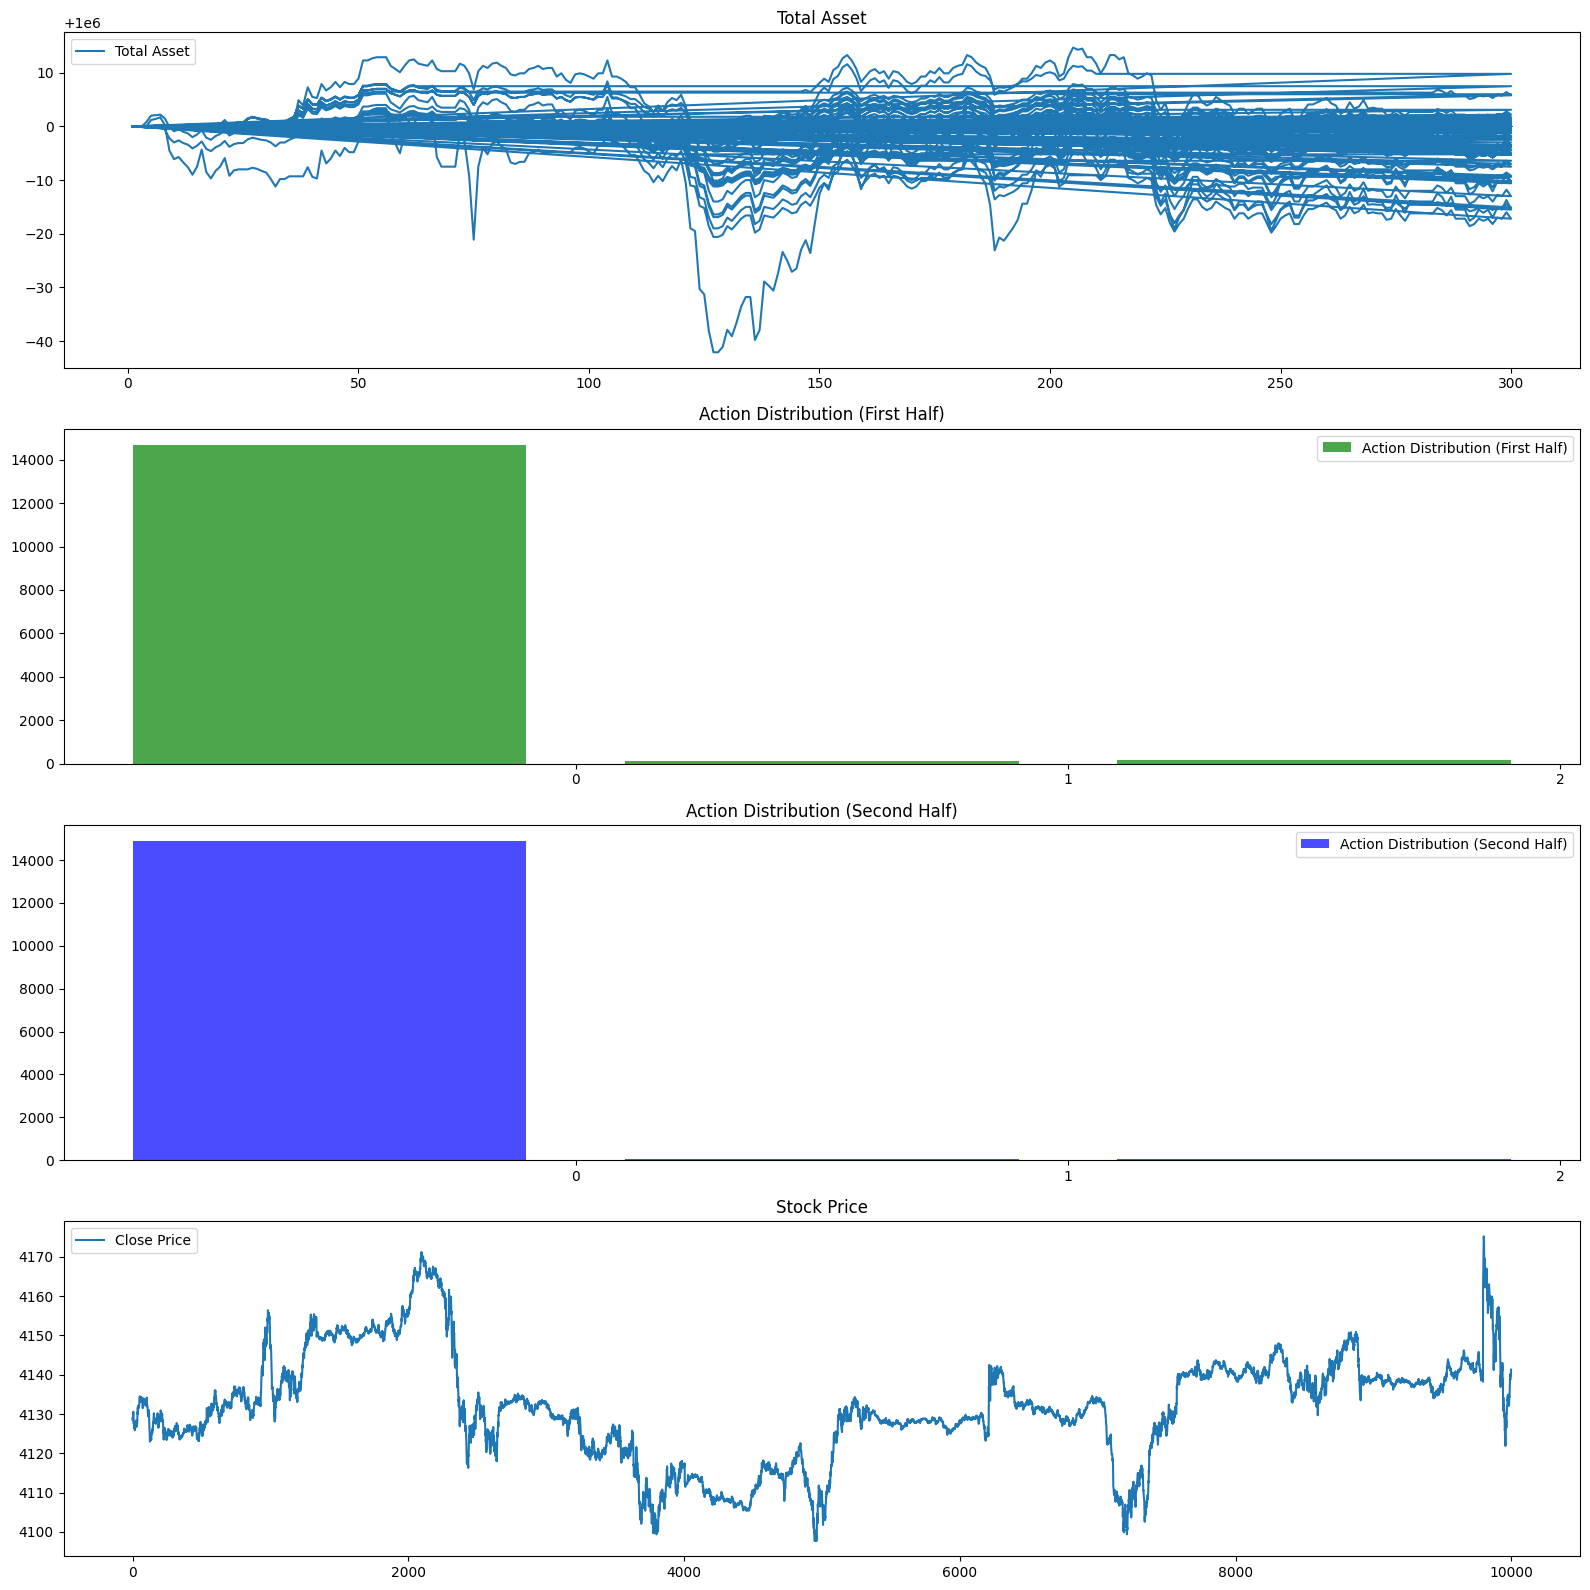

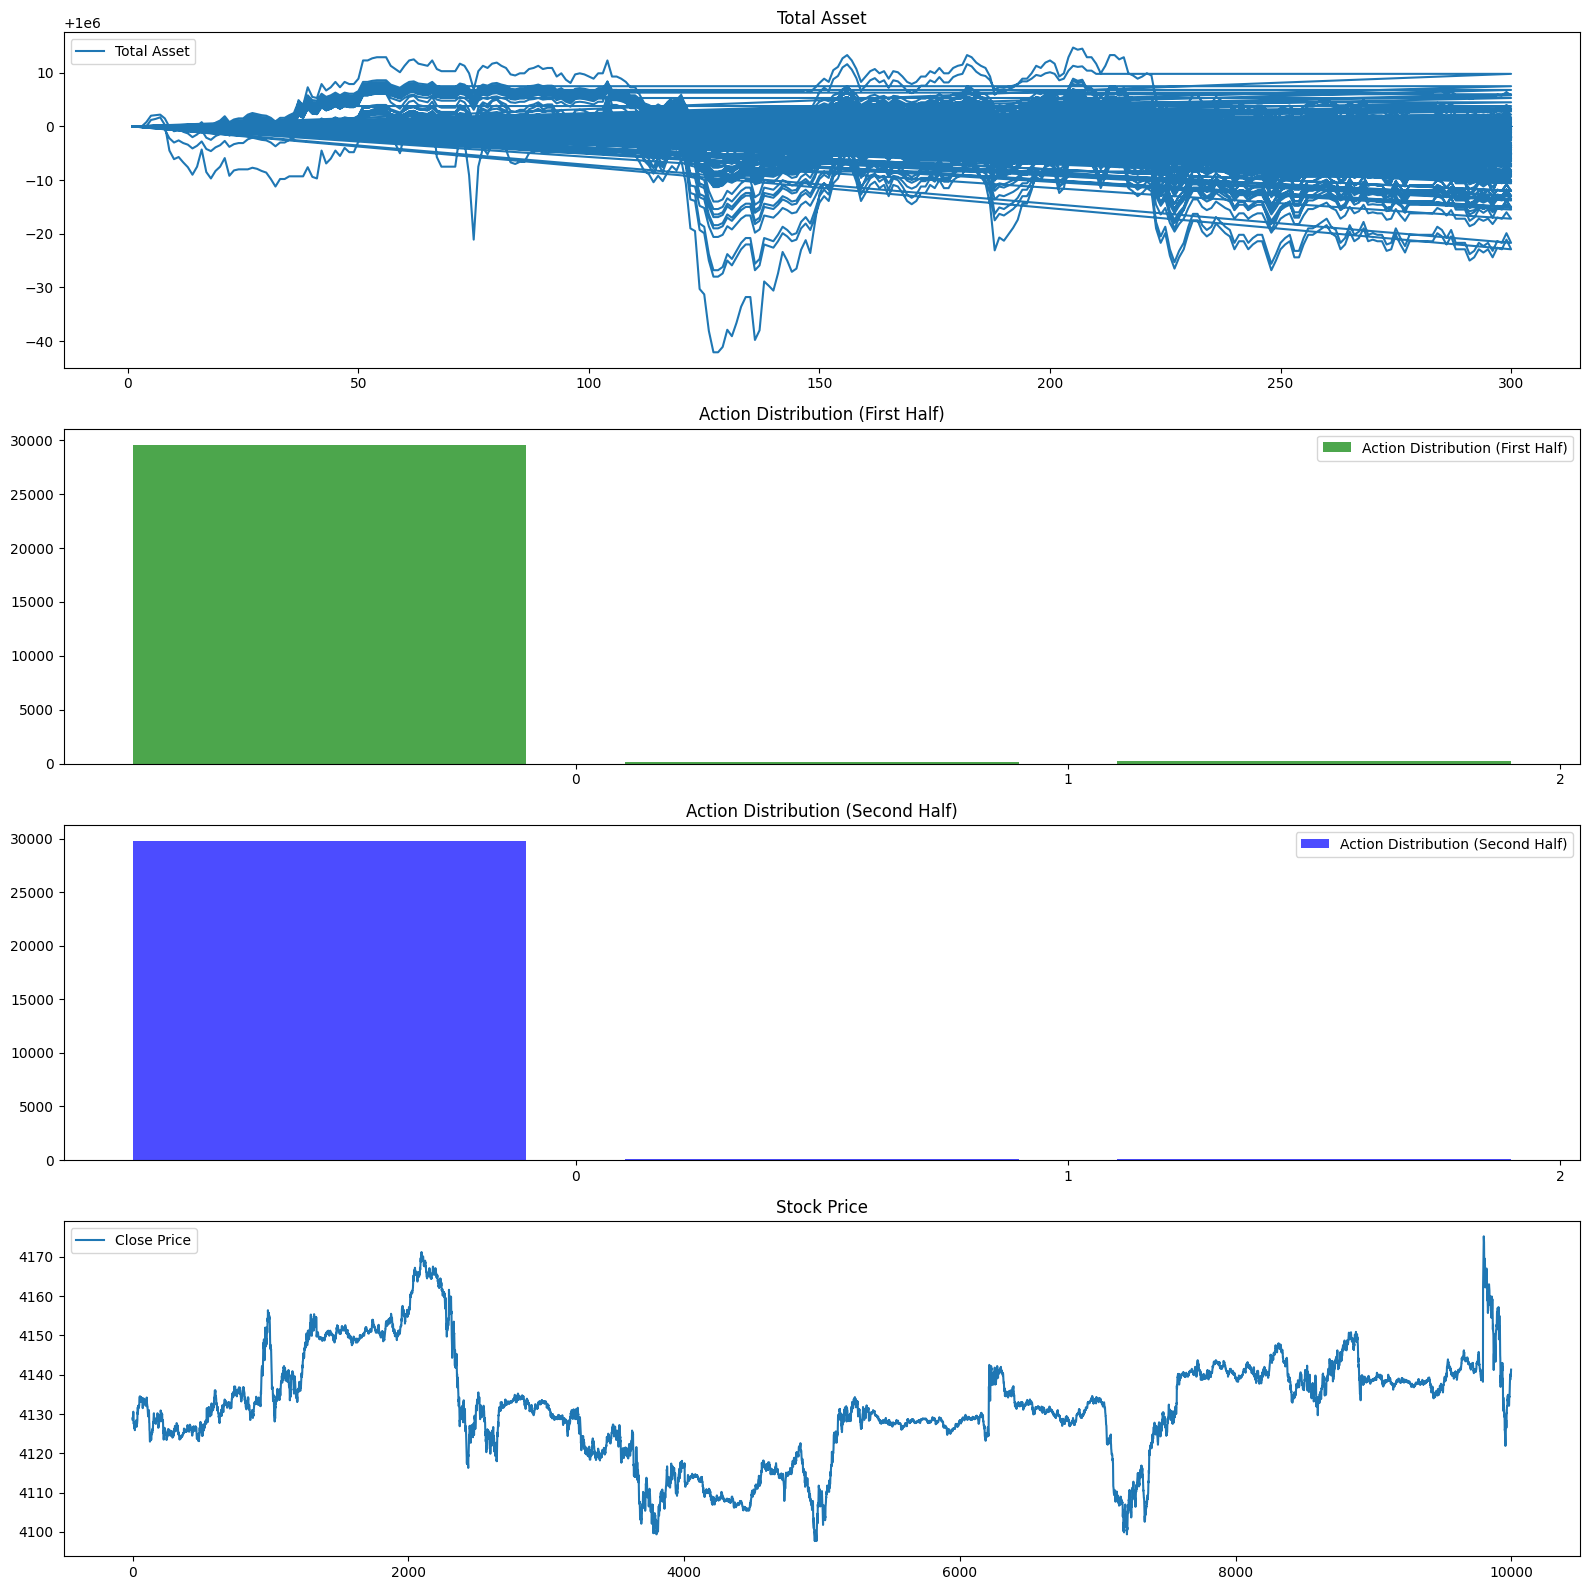

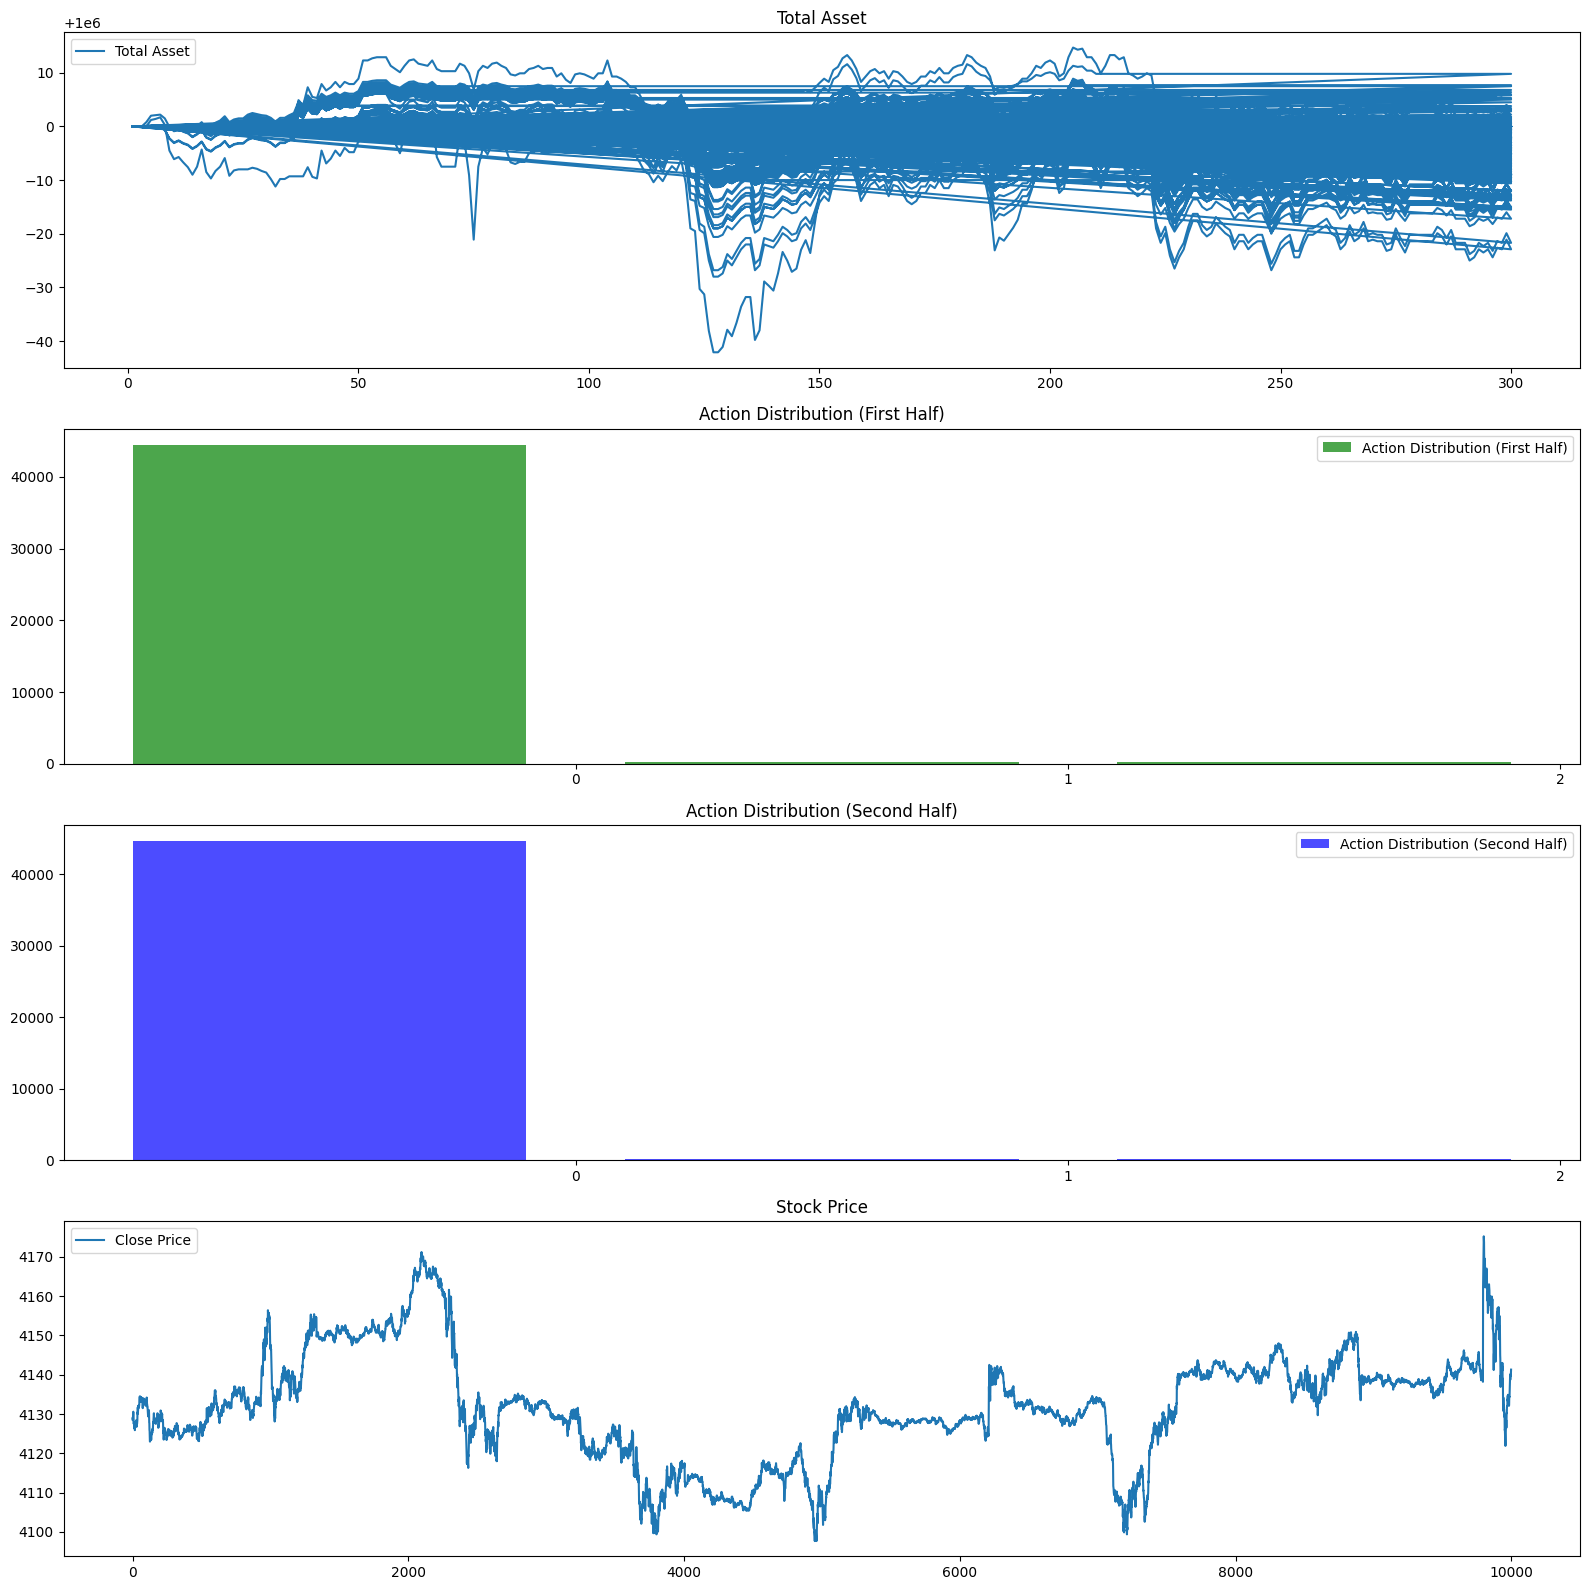

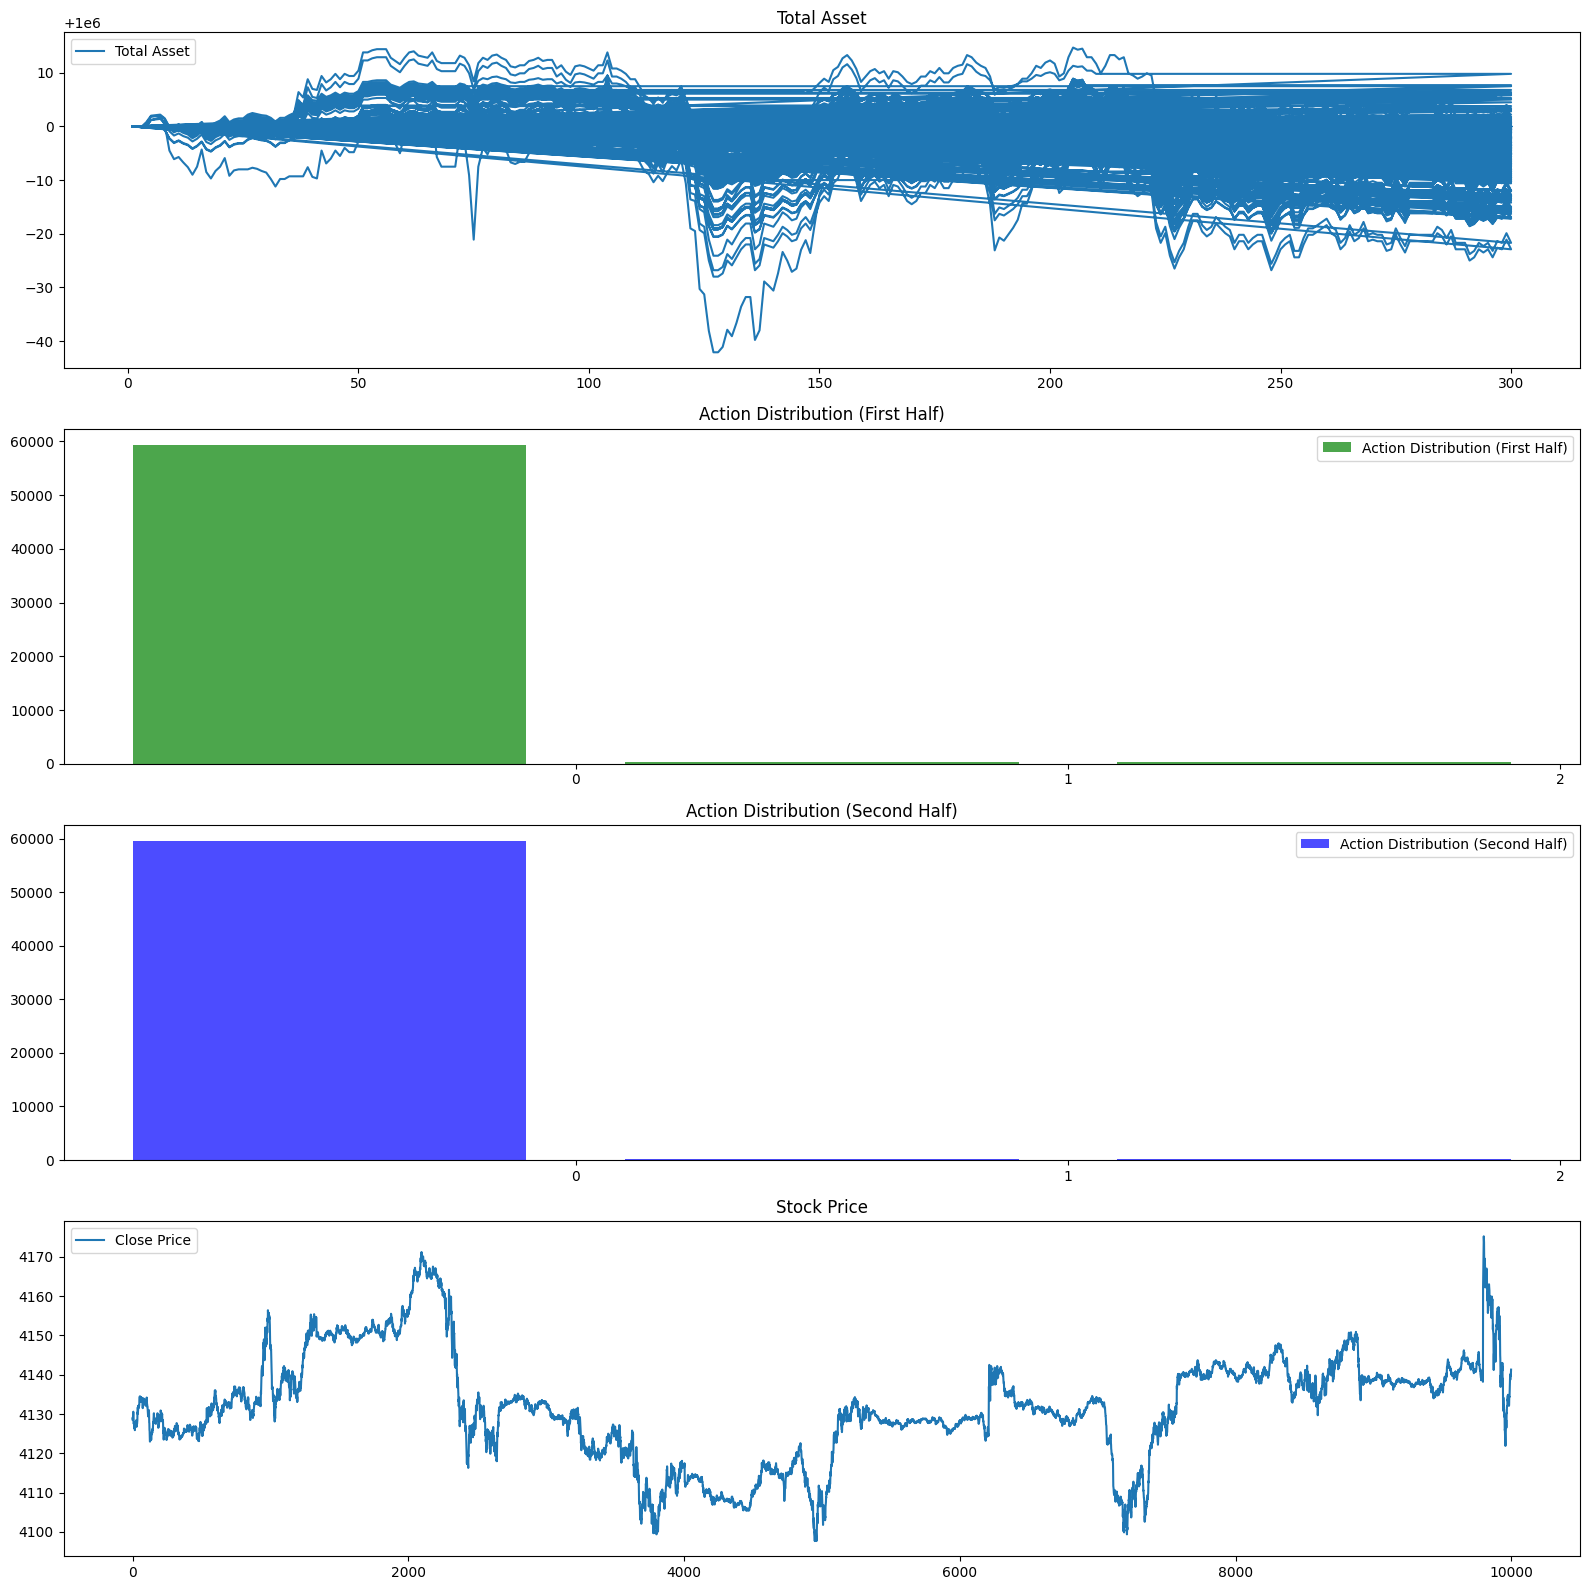

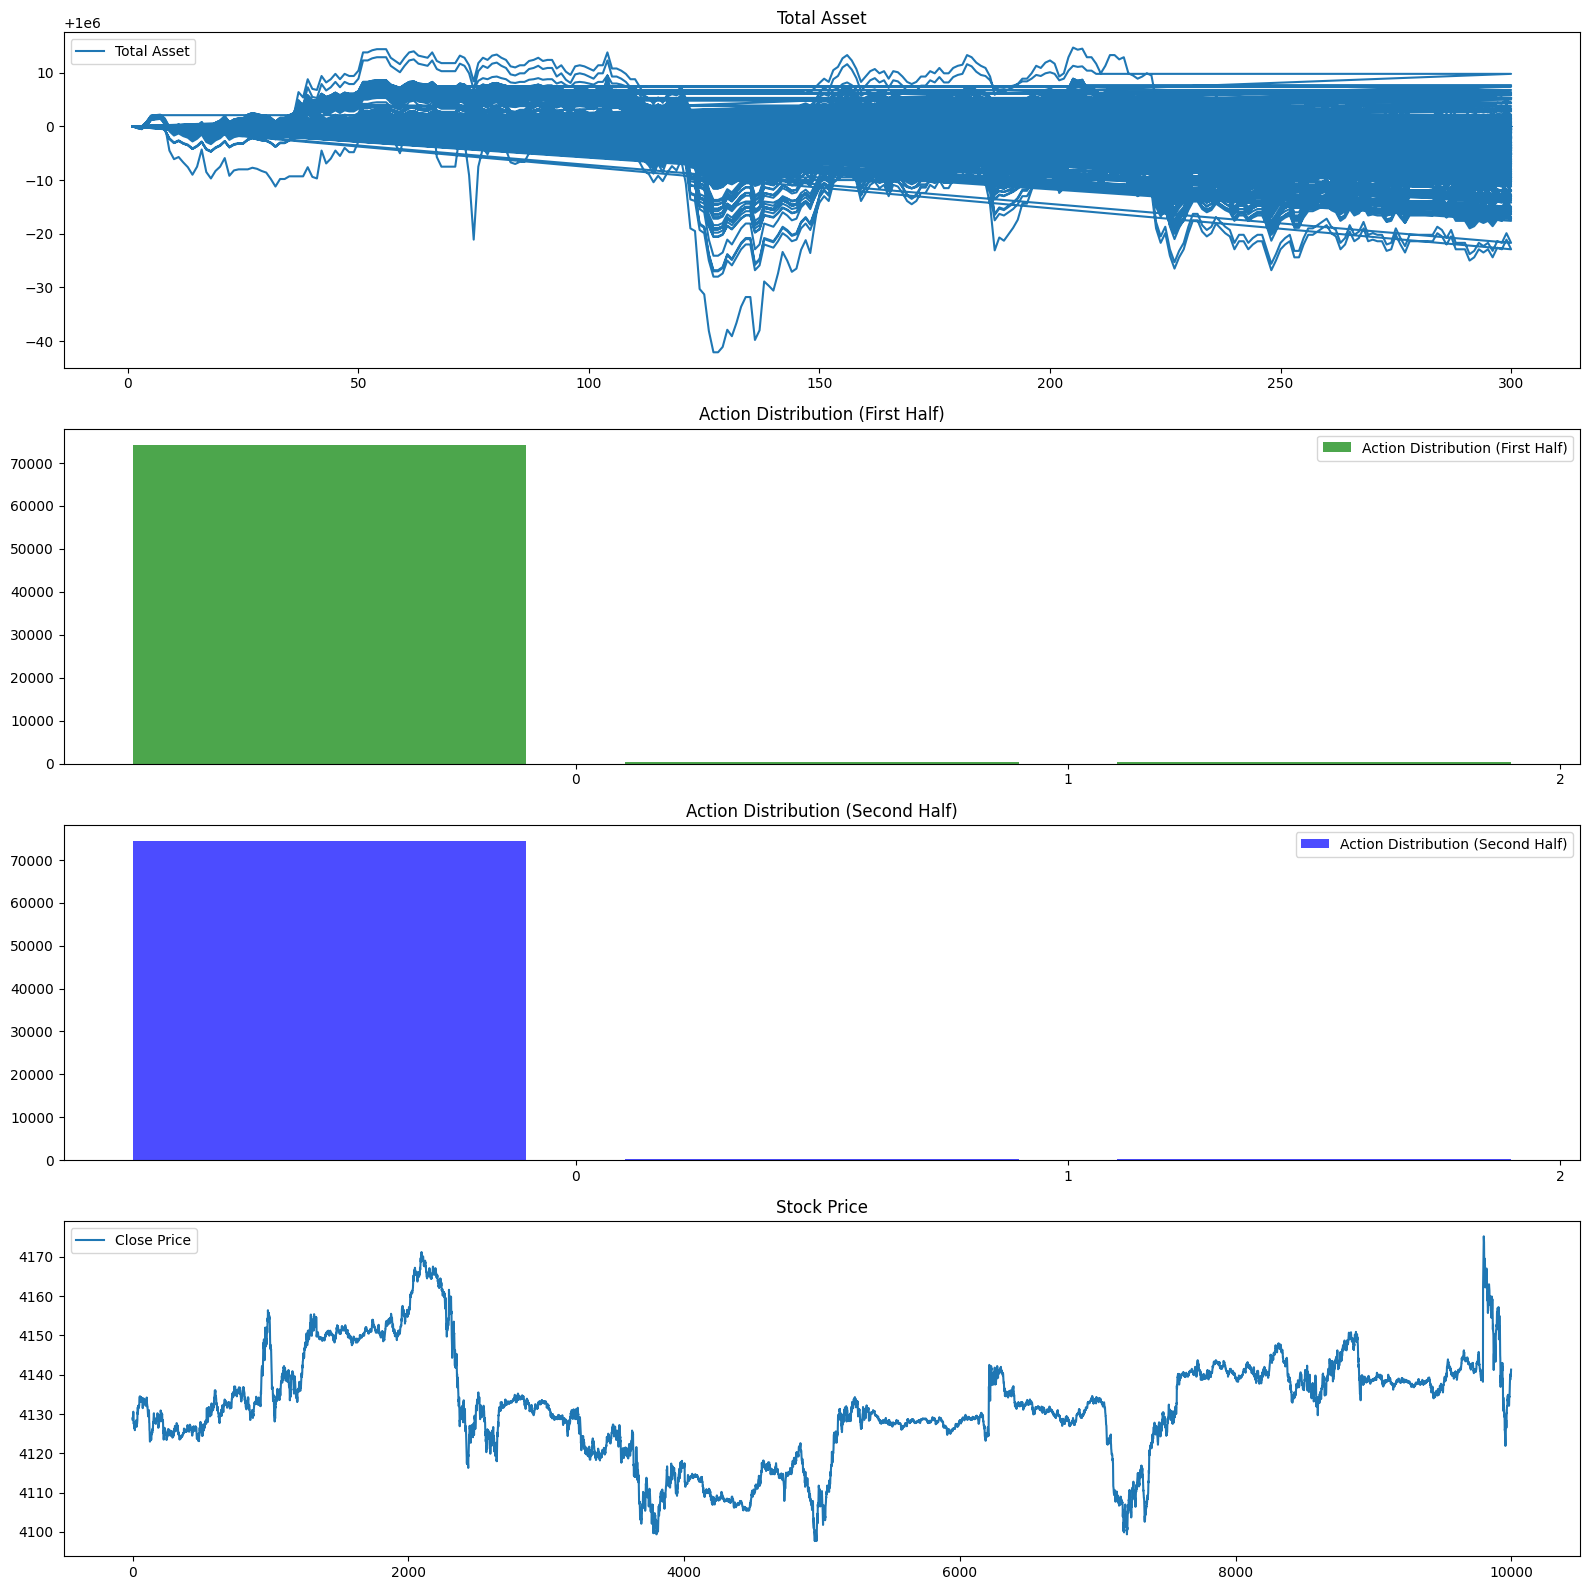

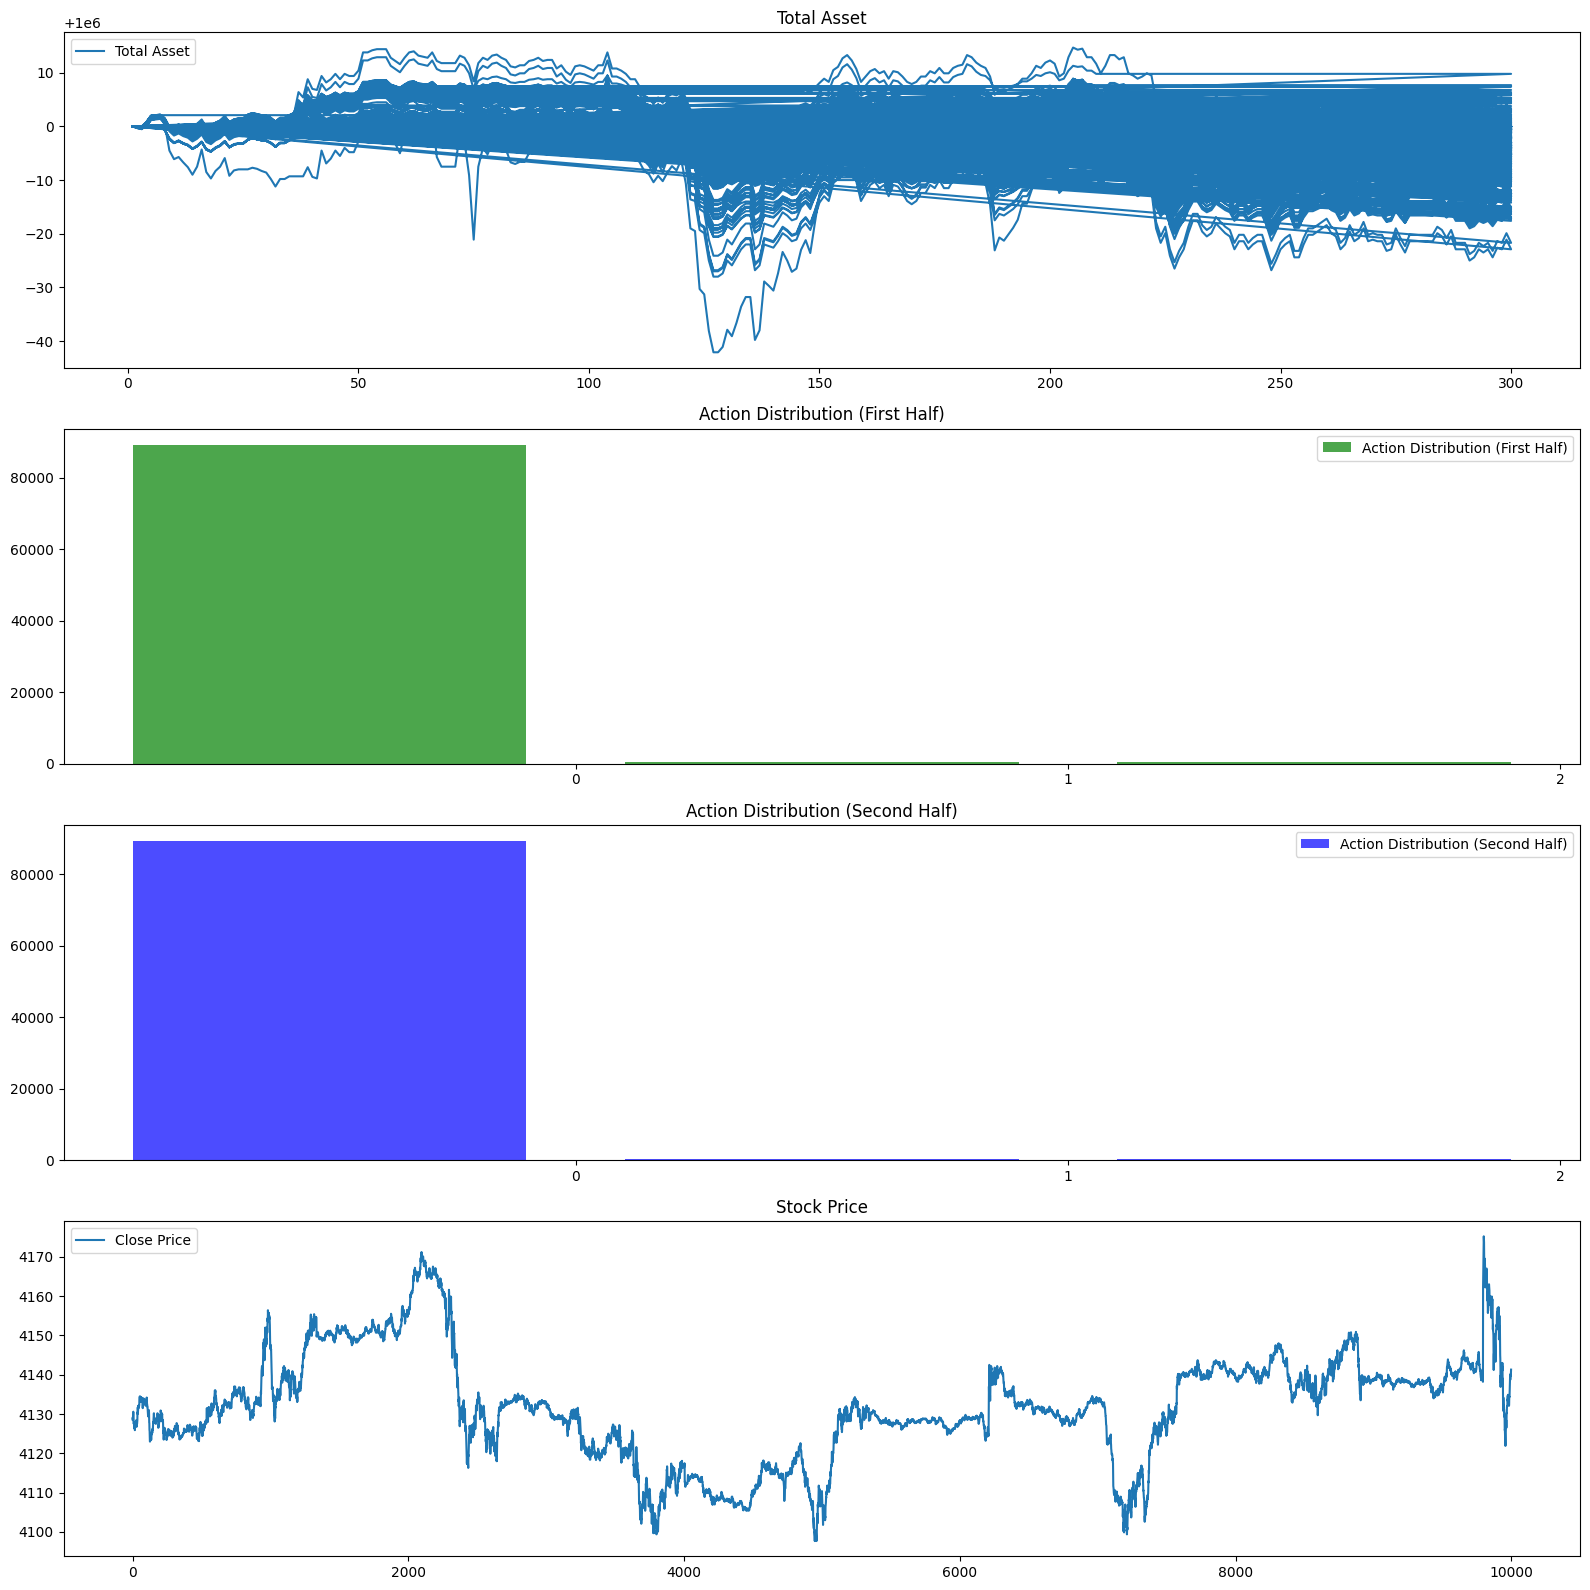

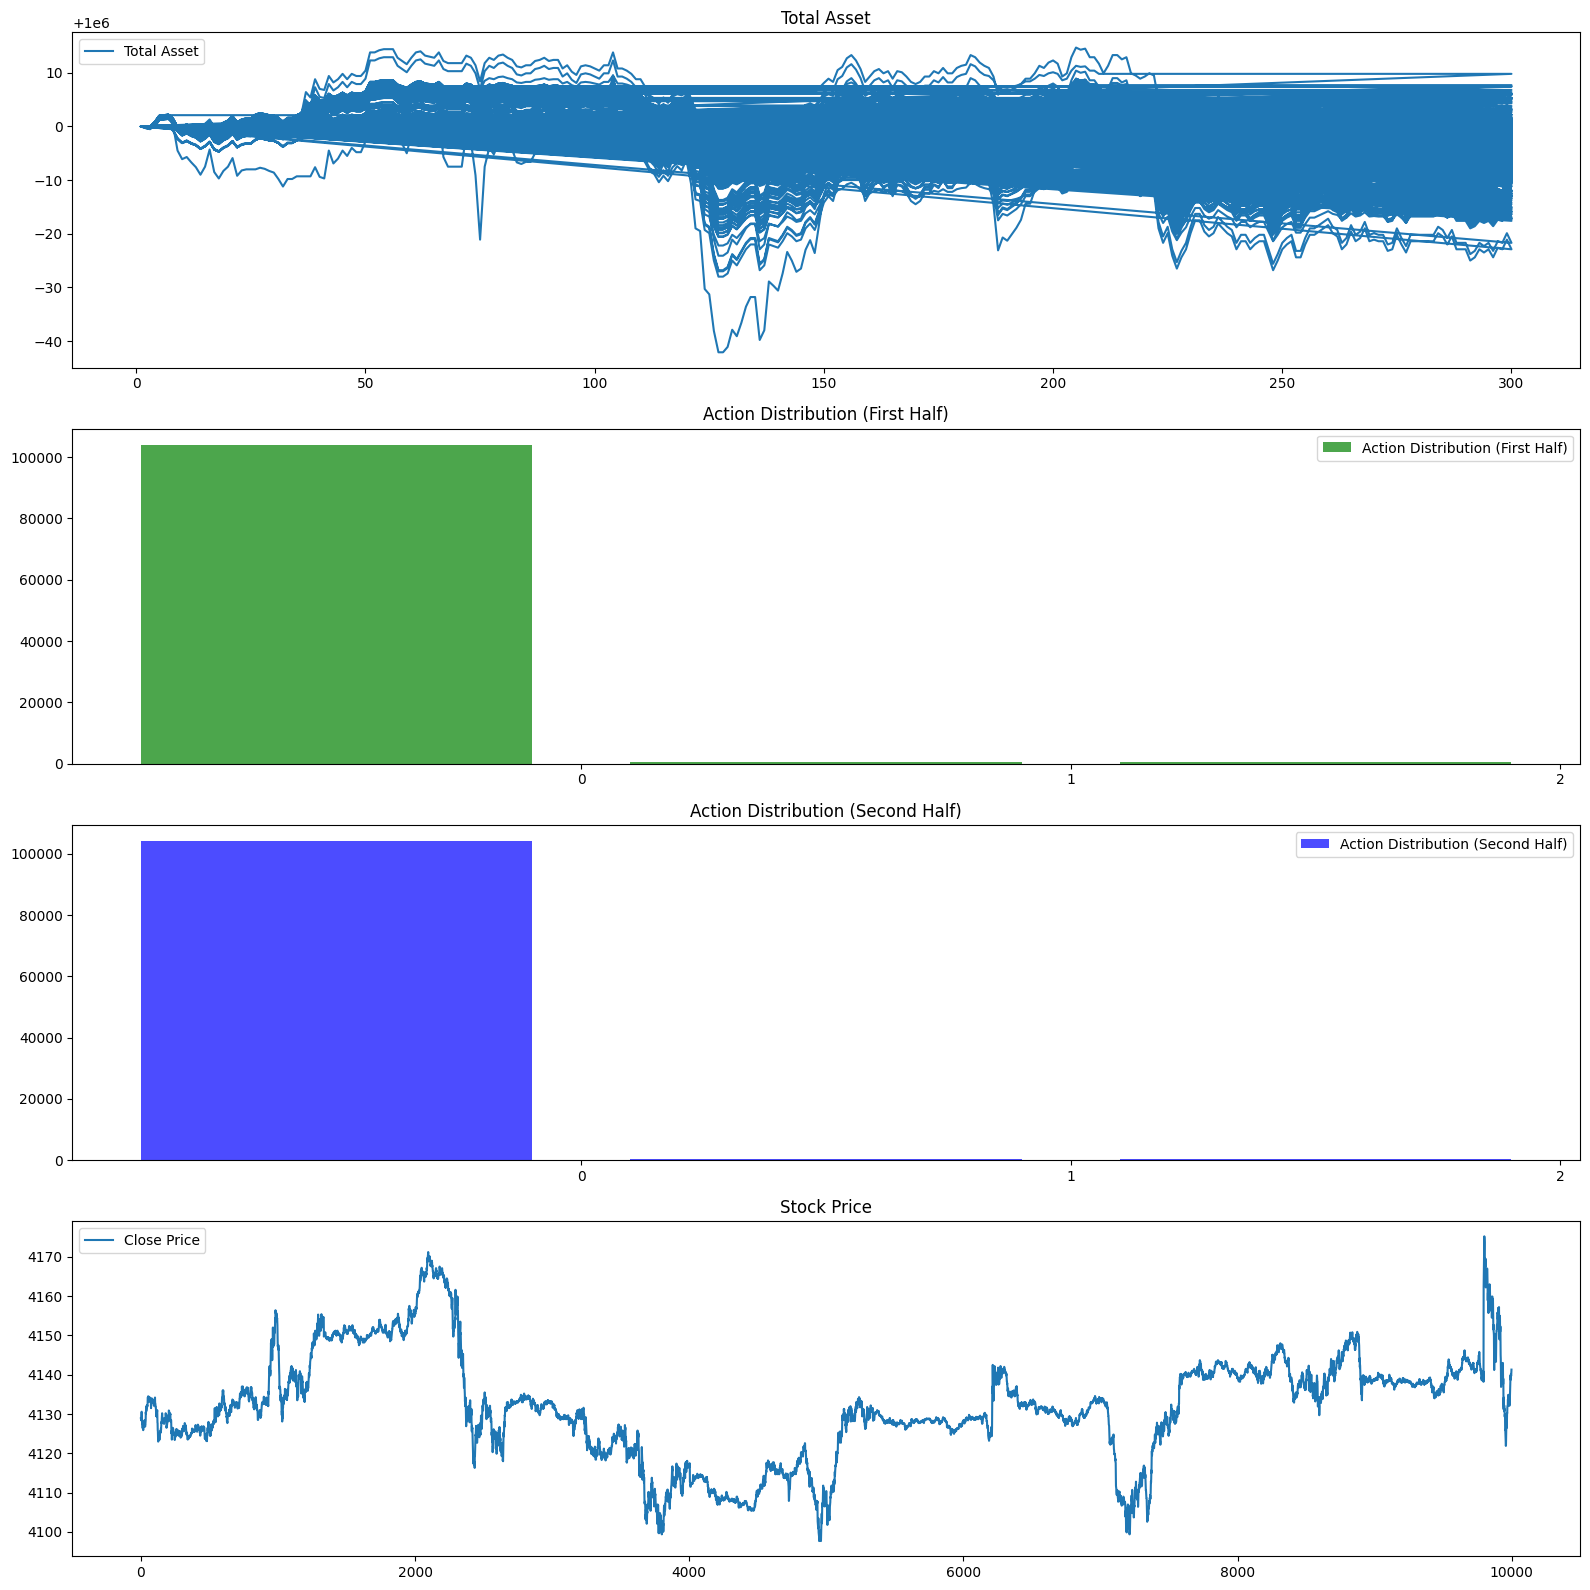

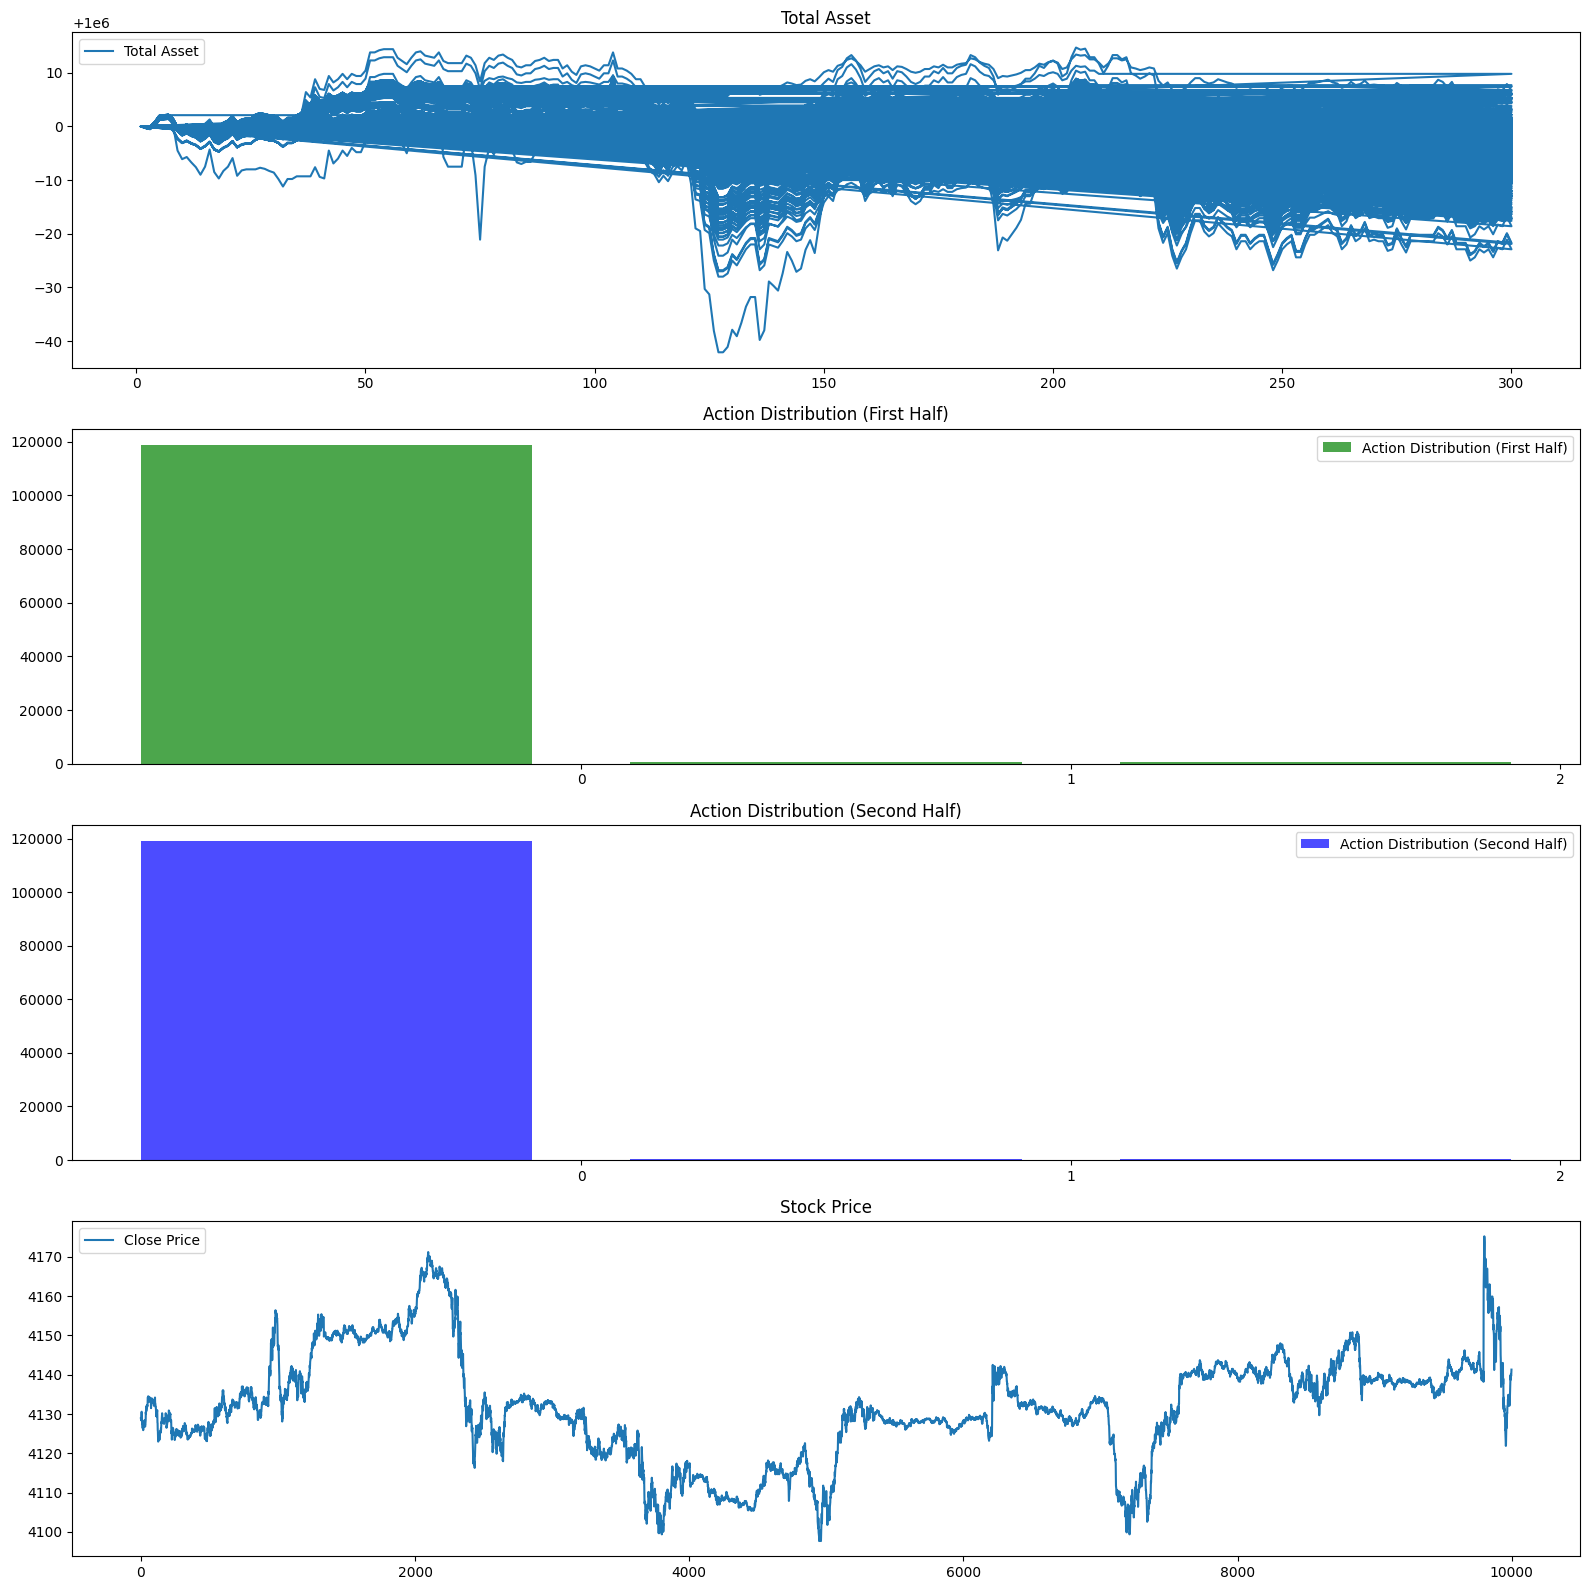

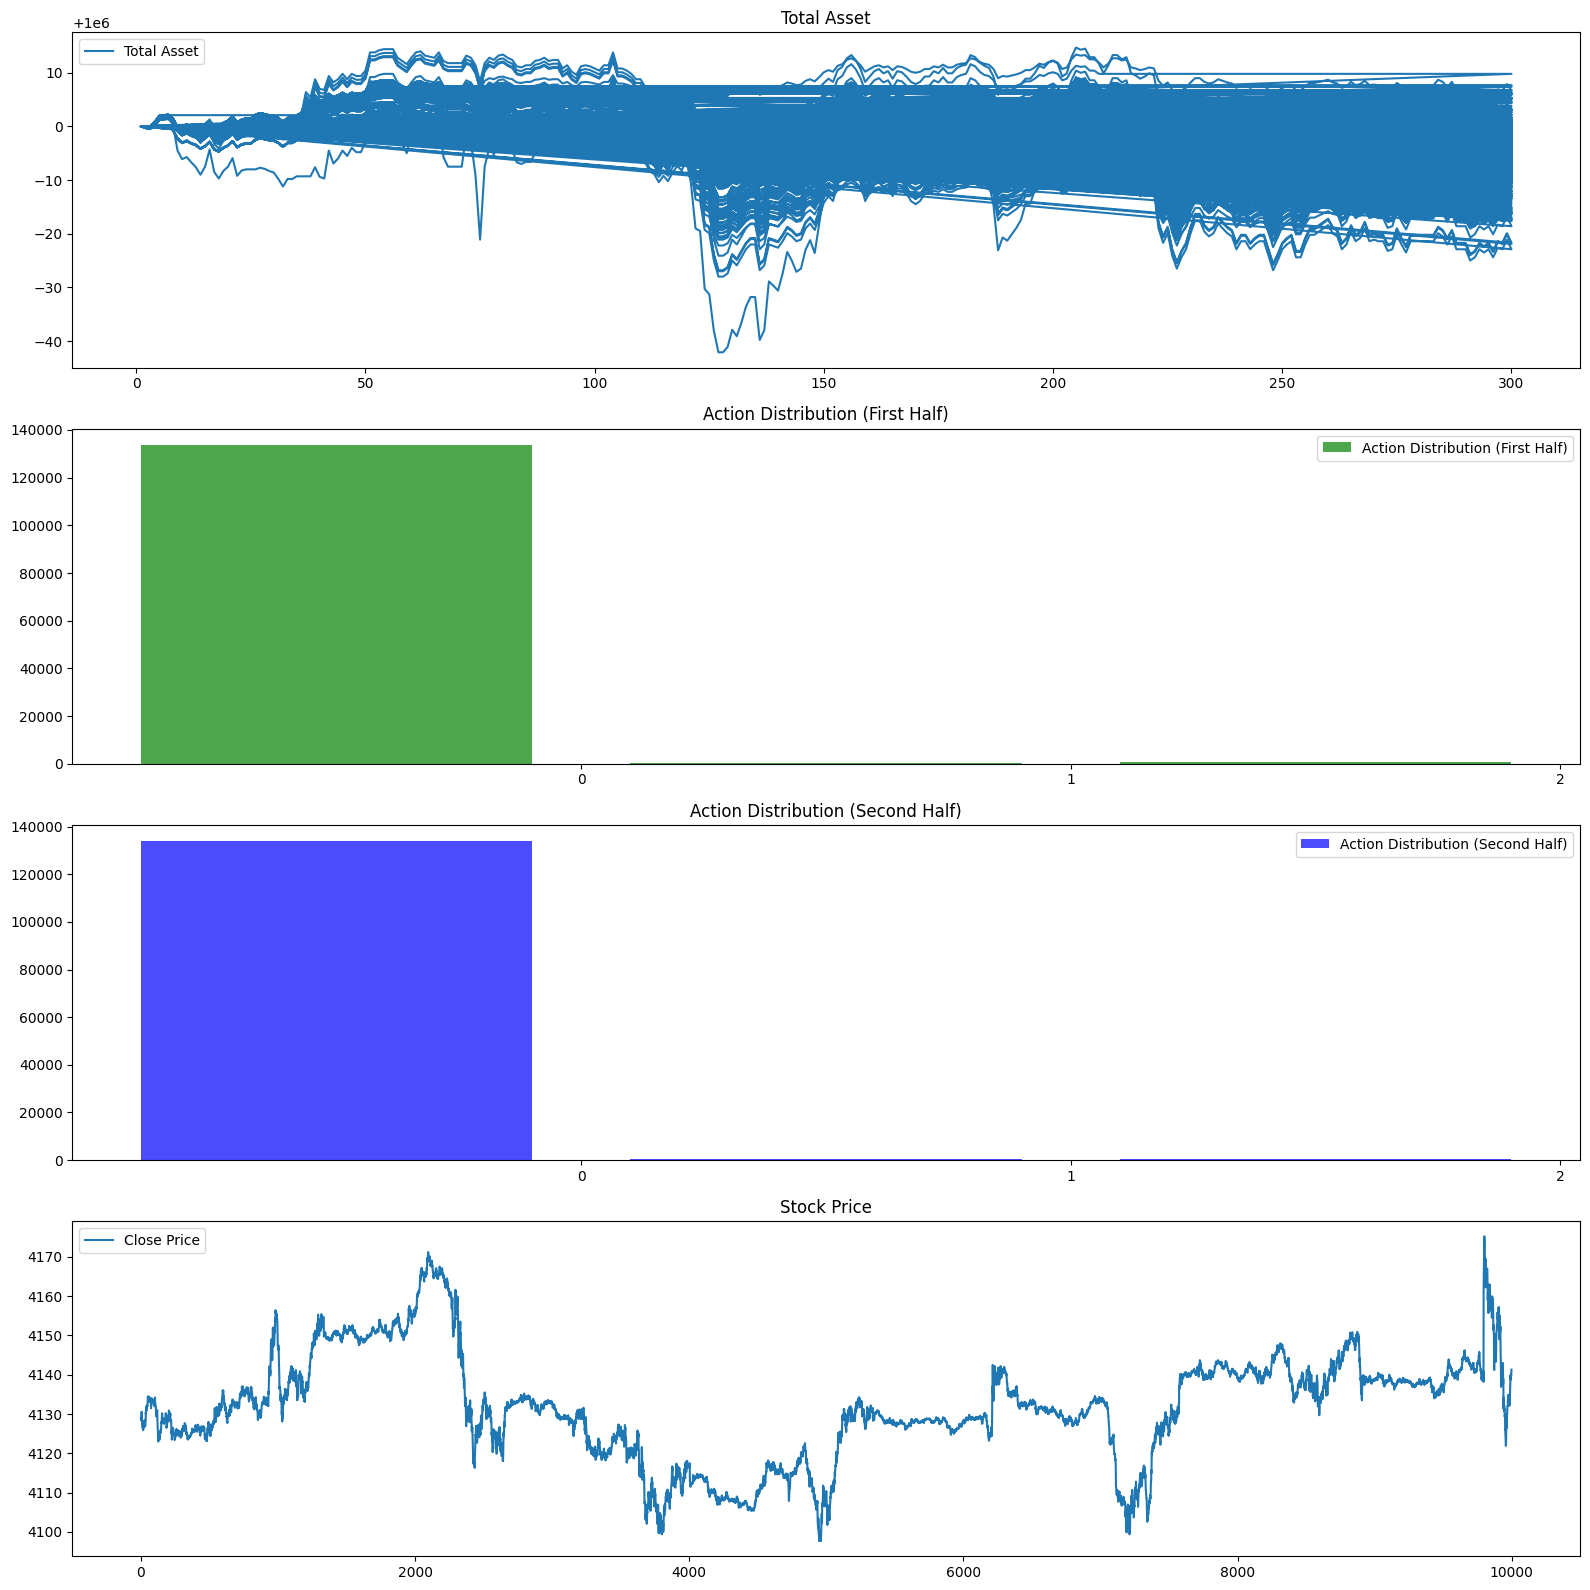

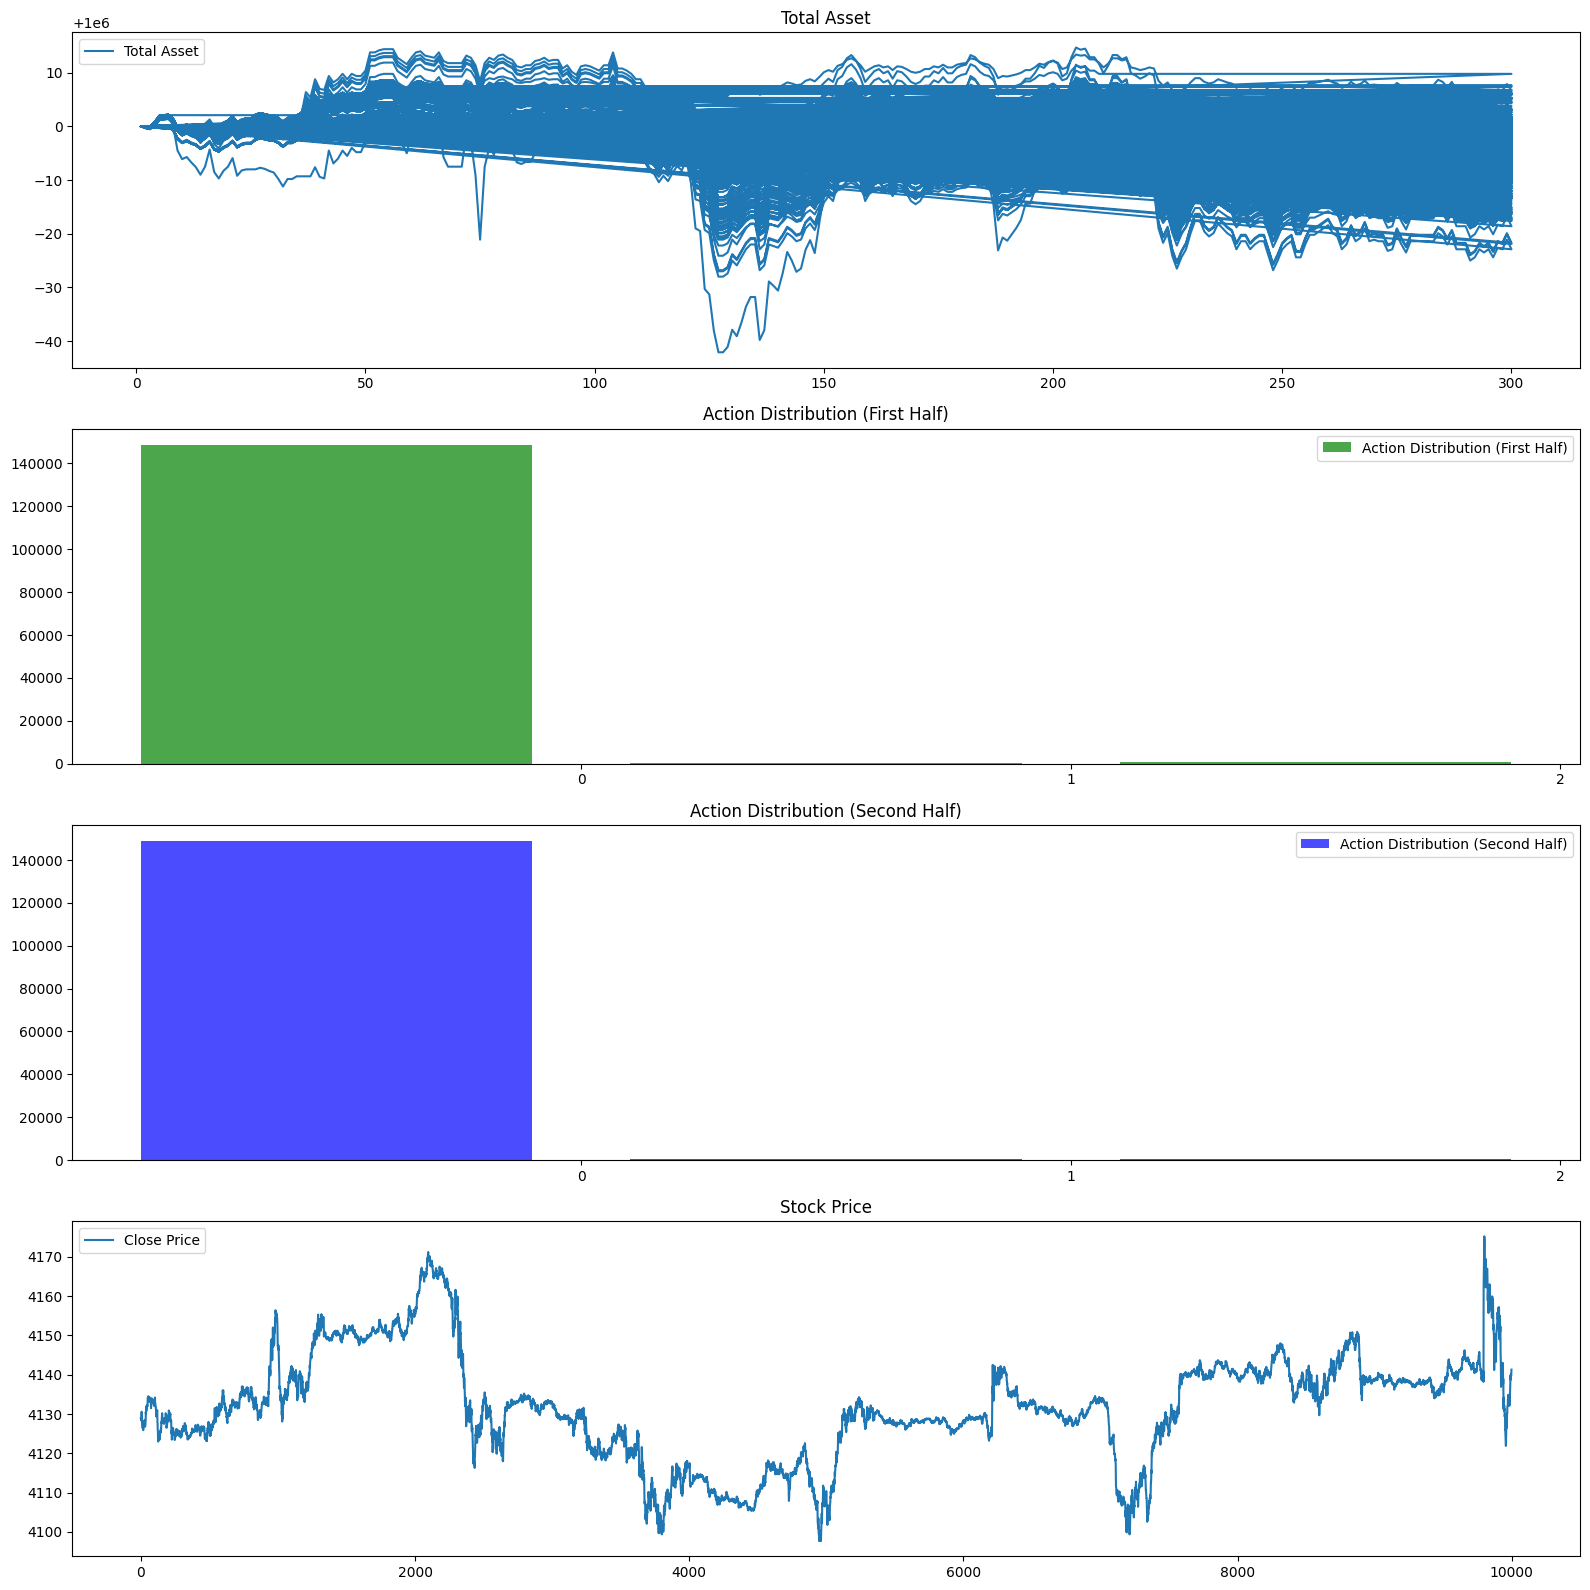

In [74]:
df = pd.read_csv('../csv/test_combined_data_10000.csv')

# 日付は文字列のまま読み込むことができないため、最小の日付からの経過秒数に変換
df['date'] = pd.to_datetime(df['date'])
df['date'] = (df['date'] - df['date'].min()).dt.total_seconds()
display(df)

df = feature_engineering(df)
display(df)

# Initialize the environment and the agent
env = TradingEnv(df)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = Agent(env, state_size, action_size)

# Run the main training loop
EPISODES = 1000
for e in range(EPISODES):
    agent.learn(e, EPISODES)
    if (e+1) % 100 == 0:
        env.plot_history()

In [75]:
agent.save_model()

In [67]:
print(agent.rewards_history)


[]


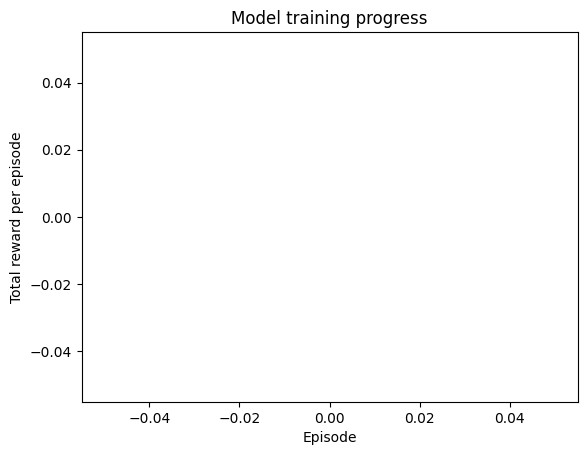

ValueError: v cannot be empty

In [66]:
plt.plot(agent.rewards_history)
plt.title('Model training progress')
plt.ylabel('Total reward per episode')
plt.xlabel('Episode')
plt.show()

# Calculate moving average of rewards
moving_avg = np.convolve(agent.rewards_history, np.ones((10,))/10, mode='valid')

plt.plot(moving_avg)
plt.title('Model training progress (Moving average of last 10 rewards)')
plt.ylabel('Average reward per episode')
plt.xlabel('Episode')
plt.show()